In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

#### Danieli et al 2023

They have 27 host galaxies in their local volume sample. They select the host halo mass of each galaxy 50 times to account for the scatter at fixed stellar mass (assuming 0.15 dex). This gives them 50 local volume realizations, similar to Nadler's 45 MW zoom-in simulations.

Importantly they, only have 280 unique merger trees (280 unique accretion histories) to sample from. We want to know how often they reuse each merger tree when selecting their 27x50 hosts. Since we don't know the stellar masses of each ELVES host galaxy, we can approximate thier sample by tring to match Figure 3 in their paper. I found that a Gaussian distribution centered on Mhost = 12.3 with a width of 0.23 dex qualitatively matches their local volume mass function. Below you can see 50 draws from that Gaussian.

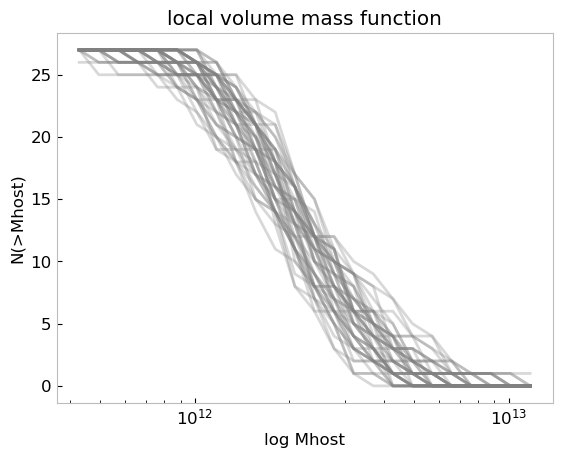

In [2]:
binz = np.linspace(11.6, 13.1, 25) # in log halo mass
plt.title("local volume mass function")
for i in range(50): # just to match the figure
    data, binr = jsm_stats.cumulative(np.random.normal(loc=12.3, scale=0.23, size=(27)), mass_bins=binz, return_bins=True)
    plt.plot(10**binr, data, color="grey", alpha=0.3)
plt.xscale("log")
plt.ylabel("N(>Mhost)")
plt.xlabel("log Mhost")
plt.show()

So lets just start of with a single 27x50 sample...

----

In [3]:
Danieli_binz = np.linspace(10.5, 13.3, 281) # so that their are 280 bincenters

single_sample = np.random.normal(loc=12.3, scale=0.23, size=(27*50)) # this is their full sample

counts = np.histogram(single_sample, bins=Danieli_binz)

bin_centers = (counts[1][:-1] + counts[1][1:]) / 2

In [4]:
counts[0] # these are counts for the 280 bins!

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  2,  0,  1,  0,
        2,  0,  0,  0,  1,  1,  1,  2,  2,  1,  2,  5,  9,  3,  2,  5,  3,
        3,  5,  1,  7,  5,  3,  7,  4,  7,  5,  9,  8,  8,  9,  8,  8, 13,
        9, 12, 19, 10, 17, 16, 12, 19,  7, 21, 21, 18, 13, 16, 16, 27, 15,
       17, 18, 20, 21, 21, 29, 14, 28, 18, 23, 24, 30, 30, 26, 22, 33, 24,
       19, 22, 19, 19, 20, 25, 20, 18, 23, 18, 23, 15, 18, 12, 14, 21, 12,
        7, 12, 13, 22, 11, 13,  9,  7,  4,  6, 11, 13,  7,  6,  2,  6,  7,
        5,  7,  3,  3,  7

In [5]:
Nbins_used = sum(counts[0] >= 1) # lets just count how many of the 280 bins got a hit, Ill call this a unique merger tree!
Nbins_used

124

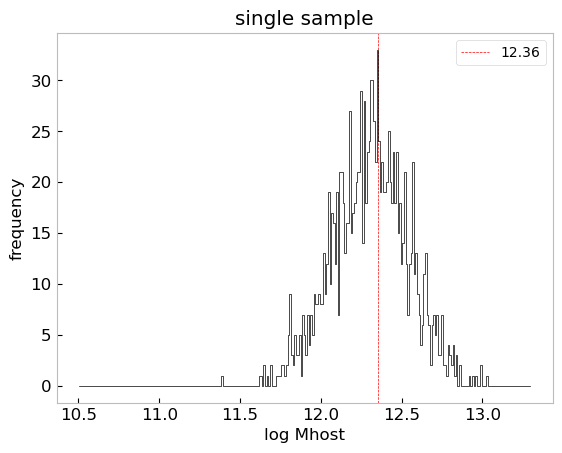

In [6]:
max_index = np.where(counts[0] == max(counts[0]))[0][0]
plt.title("single sample")
plt.axvline(bin_centers[max_index], color="red", ls="--", lw=0.5, label=f"{bin_centers[max_index]:.2f}")
plt.step(bin_centers, counts[0], lw=0.5, color="black")
plt.xlabel("log Mhost")
plt.ylabel("frequency")
plt.legend()
plt.show()

Only 128 of the 280 bins were selected in this particular draw, with the vast majority being above ~11.5 in halo mass.

The log Mhost = 12.25 bin happened to be the one with the most counts: 32 out of 1350 (roughly 2% of the sample).

Lets do this several times and see what we find...

----

In [7]:
Nrepeate = 10000

multi_sample = np.random.normal(loc=12.3, scale=0.23, size=(Nrepeate, 27*50)) # lets run it 10000 times!

counts_mat = np.zeros(shape=(Nrepeate, bin_centers.shape[0])) # just to store the histograms
for i,vals in enumerate(multi_sample):
    counts_mat[i] = np.histogram(vals, bins=Danieli_binz)[0]

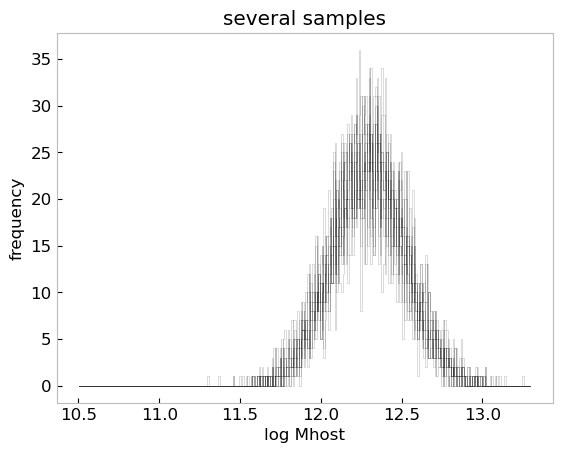

In [8]:
plt.title("several samples")
for i in range(10): # 10 just to visualize the scatter
    plt.step(bin_centers, counts_mat[i], lw=0.5, color="black", alpha = 0.2)
plt.xlabel("log Mhost")
plt.ylabel("frequency")
plt.show()

lets see on average how many unique merger trees are sampled...

In [9]:
unique = np.sum(counts_mat >= 1, axis=1) # this averages over the Nrepeate=10000 samples

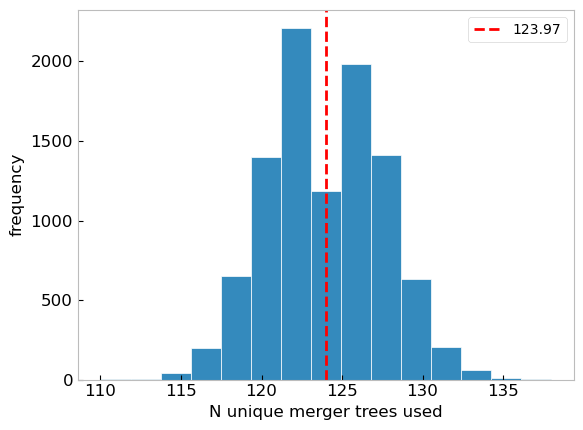

In [10]:
plt.hist(unique, bins=15, edgecolor="white")
plt.axvline(np.average(unique), color="red", ls="--", label=f"{np.average(unique):.2f}")
plt.xlabel("N unique merger trees used")
plt.ylabel("frequency")
plt.legend()
plt.show()

So on average only ~124 unique merger trees out of 280 are used in their modeling!

That is ~45% of their sample! Importantly, the vast majority of these 124 trees are being selected more than once!

lets normalize the histogram from before to see what percentage of the 1350 samples fall into each bin

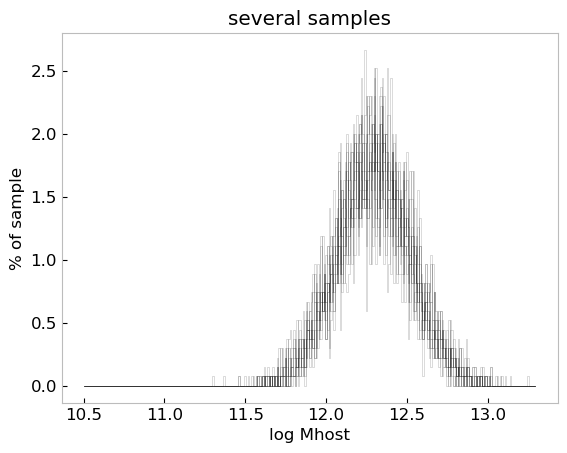

In [11]:
plt.title("several samples")
for i in range(10): # 10 just to visualize the scatter
    plt.step(bin_centers, 100*(counts_mat[i]/(1350)), lw=0.5, color="black", alpha = 0.2)
plt.xlabel("log Mhost")
plt.ylabel("% of sample")
plt.show()

So we can that roughly 2% of the 1350 selections fall in the ~40 bins between 12.1 < log Mhost < 12.5

---

now lets play with scatter at fixed stellar mass, since after all we are just assuming its 0.23 dex....

In [12]:
def samplesize_test(loc, sigma, Nbinz, Ndanieli):
    Nrepeate = 100
    lgMh_draws = np.random.normal(loc=loc, scale=sigma, size=((Nrepeate, Ndanieli)))

    lgMh_grid = np.linspace(10.5, 13.3, Nbinz)
    
    counts = np.zeros(shape=(Nrepeate, Nbinz-1))
    for i,vals in enumerate(lgMh_draws):
        counts[i] = np.histogram(vals, bins=lgMh_grid)[0]

    Nbins_used = np.sum(counts > 0.0, axis=1)

    return np.array([np.average(Nbins_used), np.std(Nbins_used)]), counts

In [13]:
Nsigma = 50
scatter = np.linspace(0.0, 0.5, Nsigma)
Nbins_used_more_than = np.zeros(shape=(Nsigma, 2))
Nbins_used = np.zeros(shape=(Nsigma, 2))
Nsamples = 27*50
Nbins = 280

for i,sigma in enumerate(scatter):
    Nbins_used_i, test = samplesize_test(12.3, sigma, Nbinz=Nbins, Ndanieli=Nsamples)
    Nbins_used[i] = Nbins_used_i

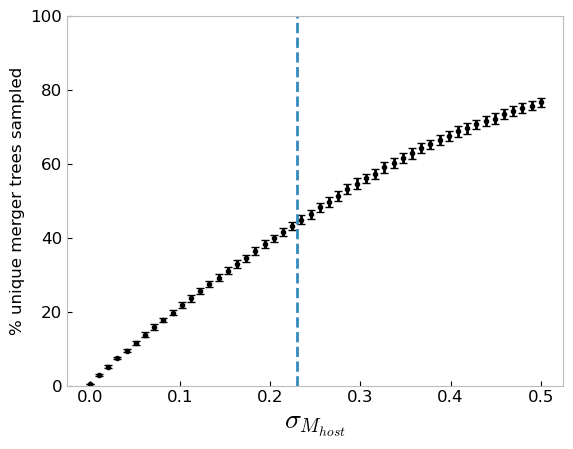

In [14]:
plt.errorbar(scatter, (Nbins_used[:,0]/Nbins)*100, yerr=(Nbins_used[:,1]/Nbins)*100, capsize=3, fmt=".", color="k")
plt.xlabel("$\\sigma_{M_{host}}$", fontsize=20)
plt.ylabel("% unique merger trees sampled")
plt.axvline(0.23, ls="--")
plt.ylim(0,100)
plt.show()

In [ ]:
full = np.load("../../../data/MW-analog/meta_data_psi3/Danieli-stats/models.npz")

np.savez(metadir+"models.npz",
        host_mass = Mhosts_mat,
        mass = acc_surv_lgMh_mat,
        redshift = acc_red_mat)